# Emotive: Facial Emotion Recognition
The objective of this notebook is to train an AI model capable of recognizing emotions on people's faces using deep neural networks.

## Setup
To begin, I will import the necessary libraries and check that a GPU is available for training. Training of this notebook is expected to be conducted on Google Colab.

### Weights & Biases Tracking
To track the model training, I make use of Weights & Biases, a ML model tracking tool

In [1]:
%%capture
!pip install wandb

In [2]:
import wandb
# 23c74d0b24c250fc7fe6df6c59e5ee5bca3340cd
wandb.login() # If running on Google Colab, will automatically login to your Google account linked with Weights and Biases

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

### Library Imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from collections import Counter
from tensorflow.keras import Model, Input
from tensorflow.keras import layers as tfl
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import  EarlyStopping, TerminateOnNaN, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.models import load_model
from wandb.keras import WandbCallback

## Data Preparation
### Dataset
The dataset used is the Facial Expression Recognition 2013 dataset, which contains 30000 facial images with different expressions of size 48x48.

It was found that the FER dataset labels were not of high quality, and thus additional work was done by researchers to do crowd-sourced tagging to provide better quality ground truths. 10 Taggers were asked to provide a label for each image into 8 categories: neutral, happiness, surprise, sadness, anger, disgust, fear, contempt.

I collected this data, and created a script that would assign the majority voted label to each image. The script is shown below:

```python

import os
import csv
import argparse
import numpy as np
from itertools import islice
from PIL import Image

# List of folders for training, validation and test.
folder_names = {'Training'   : 'FER2013Train',
                'PublicTest' : 'FER2013Valid',
                'PrivateTest': 'FER2013Test'}

classes = [
    "Neutral", "Happiness", "Surprise", "Sadness", "Anger", "Disgust", "Fear", "Contempt"
]

def str_to_image(image_blob):
    ''' Convert a string blob to an image object. '''
    image_string = image_blob.split(' ')
    image_data = np.asarray(image_string, dtype=np.uint8).reshape(48,48)
    return Image.fromarray(image_data)

def main(base_folder, fer_path, ferplus_path):
    '''
    Generate PNG image files from the combined fer2013.csv and fer2013new.csv file. The generated files
    are stored in their corresponding folder for the trainer to use.
    
    Args:
        base_folder(str): The base folder that contains  'FER2013Train', 'FER2013Valid' and 'FER2013Test'
                          subfolder.
        fer_path(str): The full path of fer2013.csv file.
        ferplus_path(str): The full path of fer2013new.csv file.
    '''
    
    print("Start generating ferplus images.")
    
    for key, value in folder_names.items():
        folder_path = os.path.join(base_folder, value)
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
    
    ferplus_entries = []
    with open(ferplus_path,'r') as csvfile:
        ferplus_rows = csv.reader(csvfile, delimiter=',')
        for row in islice(ferplus_rows, 1, None):
            ferplus_entries.append(row)
 
    index = 0
    with open(fer_path,'r') as csvfile:
        fer_rows = csv.reader(csvfile, delimiter=',')
        for row in islice(fer_rows, 1, None):
            ferplus_row = ferplus_entries[index]
            file_name = ferplus_row[1].strip()
            class_votes = ferplus_row[2:10]
            majority_class = classes[np.argmax(class_votes)]
            if len(file_name) > 0:
                image = str_to_image(row[1])
                image_path = os.path.join(base_folder, folder_names[row[2]], majority_class, file_name)
                image.save(image_path, compress_level=0)                
            index += 1 
            
    print("Done...")
            
if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("-d", 
                        "--base_folder", 
                        type = str, 
                        help = "Base folder containing the training, validation and testing folder.", 
                        required = True)
    parser.add_argument("-fer", 
                        "--fer_path", 
                        type = str,
                        help = "Path to the original fer2013.csv file.",
                        required = True)
                        
    parser.add_argument("-ferplus", 
                        "--ferplus_path", 
                        type = str,
                        help = "Path to the new fer2013new.csv file.",
                        required = True)                        

    args = parser.parse_args()
    main(args.base_folder, args.fer_path, args.ferplus_path)

```

The resulting dataset is found in `FER+.zip`. Currently the code cell below pulls the dataset from my personal Google Drive.

In [4]:
!gdown --id 1S6QWBd9hsQDC9_PlvTrfuUT7J9X2rc7f

Downloading...
From: https://drive.google.com/uc?id=1S6QWBd9hsQDC9_PlvTrfuUT7J9X2rc7f
To: /content/FER+.zip
100% 172M/172M [00:01<00:00, 118MB/s]


In [5]:
%%capture
!unzip "FER+.zip"

The comtempt class is removed due to insufficient data for training

In [6]:
!rm "FER+/FER2013Train/Contempt" -rf
!rm "FER+/FER2013Valid/Contempt" -rf
!rm "FER+/FER2013Test/Contempt" -rf

The batch size is set as below.

In [7]:
BATCH_SIZE = 32
IMAGE_SIZE = (48, 48)

Data augmentation is applied to the data to reduce overfitting.

In [8]:
train_dir = "/content/FER+/FER2013Train"
val_dir = "/content/FER+/FER2013Valid"
test_dir = "/content/FER+/FER2013Test"

train_datagen = ImageDataGenerator(
    shear_range = 0.1,
    zoom_range = 0.1,
    rotation_range= 5,
    horizontal_flip = True
)
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    color_mode = "rgb",
)

validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    color_mode = "rgb",
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    color_mode = "rgb",
)

Found 28391 images belonging to 7 classes.
Found 3554 images belonging to 7 classes.
Found 3544 images belonging to 7 classes.


The mapping of class to index is shown below

In [9]:
train_generator.class_indices

{'Anger': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happiness': 3,
 'Neutral': 4,
 'Sadness': 5,
 'Surprise': 6}

In [10]:
classnames = list(train_generator.class_indices.keys())

## Exploratory Data Analysis

In [11]:
eda_generator = test_datagen.flow_from_directory(
    train_dir,
    target_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    color_mode = "rgb",
)

Found 28391 images belonging to 7 classes.


In [12]:
class_map = {
    v : k for k, v in eda_generator.class_indices.items()
}

In [13]:
images, labels = next(eda_generator)

In [14]:
images.min()

0.0

In [15]:
images.max()

255.0

In [16]:
Counter(map(lambda x : class_map[x], eda_generator.labels))

Counter({'Anger': 2477,
         'Disgust': 194,
         'Fear': 656,
         'Happiness': 7539,
         'Neutral': 10389,
         'Sadness': 3548,
         'Surprise': 3588})

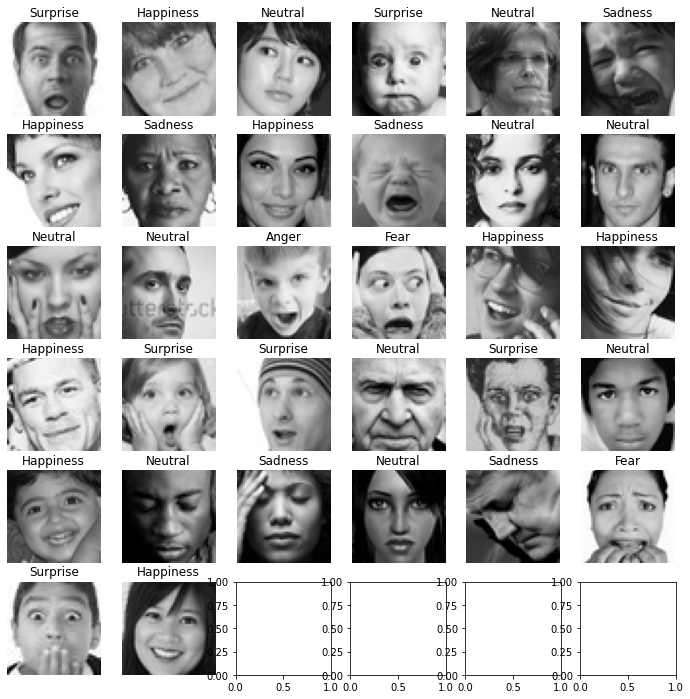

In [17]:
num_rows = int(np.ceil(np.sqrt(len(images))))

fig, ax = plt.subplots(num_rows, num_rows, figsize=(12, 12))
for image, label, subplot in zip(images, labels, ax.ravel()):
  subplot.imshow(image / 255)
  subplot.set_title(class_map[np.argmax(label)])
  subplot.axis("off")


## Model
The model I am using is a Wide Residual Network, which is a Residual Network with the width (i.e. number of filters) multiplied by a factor of K. To prevent overfitting, dropout, batch normalization and L2 regularization is applied on the network.

In [18]:
class Residual(Model):
  """
  B(3,3) block was found to perform the best
  Dropout is added between the convolutions, after activations
  Order of BN, Conv and ReLU changed to BN-Relu-Conv 
  """
  def __init__(self, num_channels, k, use_1x1conv=False, strides=1, activation='relu'):
    super().__init__() # subclassing a layer
    self.activation = tfl.Activation(activation)
    self.bn_1 = tfl.BatchNormalization(epsilon=1e-5, gamma_initializer='uniform') # 
    self.conv_1 = tfl.Conv2D(num_channels * k, 3, strides=strides, padding="same", kernel_regularizer="l2", use_bias=False, kernel_initializer='he_normal')
    self.dropout = tfl.Dropout(0.3) 
    self.bn_2 = tfl.BatchNormalization(epsilon=1e-5, gamma_initializer='uniform')
    self.conv_2 = tfl.Conv2D(num_channels * k, 3, strides=1, padding="same", kernel_regularizer="l2", use_bias=False, kernel_initializer='he_normal')
    if use_1x1conv:
      self.conv3 = tfl.Conv2D(num_channels * k, 1, strides=strides,padding="same", kernel_regularizer="l2", use_bias=False, kernel_initializer='he_normal')
    else:
      self.conv3 = None
  def call(self, X):
    Y = self.bn_1(X)
    Y = self.activation(Y)
    Y = self.conv_1(Y)
    Y = self.bn_2(Y)
    Y = self.activation(Y)
    Y = self.dropout(Y)
    Y = self.conv_2(Y)
    if self.conv3 is not None: 
      X = self.conv3(X) # shortcut connection
    Y += X
    return Y

In [19]:
class ResidualBlock(tfl.Layer):
    def __init__(self, num_channels, k, num_residuals, first_block=False, activation='relu',
                 **kwargs):
        super().__init__(**kwargs)
        self.residual_layers = []
        for i in range(num_residuals):
            if first_block:
                self.residual_layers.append(
                    Residual(num_channels, k, use_1x1conv=True, strides=1, activation=activation))              
            elif i == 0:
                self.residual_layers.append(
                    Residual(num_channels, k, use_1x1conv=True, strides=2, activation=activation))
            else:
                self.residual_layers.append(Residual(num_channels, k, strides=1, activation=activation))

    def call(self, X):
        for layer in self.residual_layers:
            X = layer(X)
        return X

In [27]:
def build_model():
    inputs = Input(shape=(48, 48, 3))
    k = 3
    x = tfl.Conv2D(16, 3, padding="same", kernel_regularizer="l2", use_bias=False, kernel_initializer='he_normal')(inputs)
    x = ResidualBlock(16, k, 4, first_block=True)(x)
    x = ResidualBlock(32, k, 4)(x)
    x = ResidualBlock(64, k, 4)(x)
    x = tfl.BatchNormalization(epsilon=1e-5, gamma_initializer='uniform')(x)
    x = tfl.Activation("relu")(x)
    # Global Pooling
    x = tfl.GlobalAveragePooling2D()(x)
    outputs = tfl.Dense(7, "softmax", kernel_regularizer="l2", kernel_initializer="he_normal")(x)
    model = Model(inputs, outputs)
    model.compile(
        optimizer = SGD(),
        loss=CategoricalCrossentropy(label_smoothing=0.1),
        metrics= ["accuracy"]
    )
    return model

### Model Training
The model is trained using stochastic gradient descent, and with label smoothing applied. Label smoothing penalizes the model for being overconfident in its predictions, hopefully increasing the generalization ability of the model on actual data. 

In [28]:
model = build_model()
print(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 conv2d_62 (Conv2D)          (None, 48, 48, 16)        432       
                                                                 
 residual_block_6 (ResidualB  (None, 48, 48, 48)       161152    
 lock)                                                           
                                                                 
 residual_block_7 (ResidualB  (None, 24, 24, 96)       629568    
 lock)                                                           
                                                                 
 residual_block_8 (ResidualB  (None, 12, 12, 192)      2512512   
 lock)                                                           
                                                           

In [29]:
wandb.init(
    project = "DOAA CA2"
)

wandb: Currently logged in as: tiencheng (use `wandb login --relogin` to force relogin)


In [30]:
model.fit(train_generator, validation_data=validation_generator, batch_size=BATCH_SIZE, callbacks=[
    TerminateOnNaN(),
    ReduceLROnPlateau(),
    EarlyStopping(monitor="val_accuracy",patience=10, restore_best_weights=True),
    WandbCallback(
        monitor="val_accuracy",
        save_model=False,
        generator=validation_generator,
        labels=classnames,
    )
], epochs=100)

Epoch 1/100
888/888 [==============================] - 60s 55ms/step - loss: 55.4033 - accuracy: 0.3638 - val_loss: 46.3660 - val_accuracy: 0.3790 - lr: 0.0100
Epoch 2/100
888/888 [==============================] - 48s 54ms/step - loss: 39.2894 - accuracy: 0.3659 - val_loss: 32.9920 - val_accuracy: 0.3790 - lr: 0.0100
Epoch 3/100
888/888 [==============================] - 46s 52ms/step - loss: 28.0327 - accuracy: 0.3663 - val_loss: 23.6201 - val_accuracy: 0.3790 - lr: 0.0100
Epoch 4/100
888/888 [==============================] - 47s 52ms/step - loss: 20.1484 - accuracy: 0.3666 - val_loss: 17.0512 - val_accuracy: 0.3787 - lr: 0.0100
Epoch 5/100
888/888 [==============================] - 46s 52ms/step - loss: 14.6155 - accuracy: 0.3667 - val_loss: 12.4466 - val_accuracy: 0.3787 - lr: 0.0100
Epoch 6/100
888/888 [==============================] - 46s 52ms/step - loss: 10.7394 - accuracy: 0.3675 - val_loss: 9.2184 - val_accuracy: 0.3793 - lr: 0.0100
Epoch 7/100
888/888 [====================

### Model Evaluation

In [31]:
model.evaluate(test_generator)

111/111 [==============================] - 2s 17ms/step - loss: 1.1175 - accuracy: 0.7867


[1.1175029277801514, 0.7866817116737366]

### Exporting Model

In [32]:
model.save("img_classifier")

INFO:tensorflow:Assets written to: img_classifier/assets


In [33]:
!tar -zcvf emotive_model.tar.gz img_classifier

img_classifier/
img_classifier/saved_model.pb
img_classifier/keras_metadata.pb
img_classifier/assets/
img_classifier/variables/
img_classifier/variables/variables.data-00000-of-00001
img_classifier/variables/variables.index


In [34]:
from google.colab import files
files.download("emotive_model.tar.gz")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>